In [6]:
import pandas as pd
import xgboost as xgb
import numpy as np
import multiprocessing as mt
from datetime import datetime
from matplotlib import pyplot as plt
from collections import OrderedDict

In [4]:
def load_data(filepath='../data/', 
              files=['members.csv', 'sample_submission_zero.csv', 'train.csv', 'transactions.csv', 'user_logs.csv'],
              nrows=[None, None, None, None, None]):

    d = []
    for f,r in zip(files,nrows): d.append(pd.read_csv(filepath+f, nrows=r))

    return d

In [5]:
%%time
members, sample_submission, train, transactions, user_logs = load_data(nrows=[None]*5)

CPU times: user 6min 42s, sys: 3min 34s, total: 10min 17s
Wall time: 10min 42s


In [11]:
set(sample_submission['is_churn']) == set(train['is_churn'])

False

In [12]:
print 'hi'

hi


In [112]:
transactions['date'] = transactions['transaction_date']
transactions['transaction'] = 1
user_logs['log'] = 1

In [114]:
user_logs[:5]

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,log
0,rxIP2f2aN0rYNp+toI0Obt/N/FYQX8hcO1fTmmy2h34=,20150513,0,0,0,0,1,1,280.335,1
1,rxIP2f2aN0rYNp+toI0Obt/N/FYQX8hcO1fTmmy2h34=,20150709,9,1,0,0,7,11,1658.948,1
2,yxiEWwE9VR5utpUecLxVdQ5B7NysUPfrNtGINaM2zA8=,20150105,3,3,0,0,68,36,17364.956,1
3,yxiEWwE9VR5utpUecLxVdQ5B7NysUPfrNtGINaM2zA8=,20150306,1,0,1,1,97,27,24667.317,1
4,yxiEWwE9VR5utpUecLxVdQ5B7NysUPfrNtGINaM2zA8=,20150501,3,0,0,0,38,38,9649.029,1


In [120]:
def join_data(data, indices=['msno', 'date']):
    logs_trans = data['logs'].merge(data['transactions'], on=[indices[0], indices[1]], how='outer')
    return logs_trans.merge(data['train'], on=indices[0], how='outer').merge(data['members'], on=indices[0], how='outer')    

In [118]:
members.merge(train, on='msno', how='outer').shape

(198243, 8)

In [119]:
members.set_index('msno').join(train.set_index('msno')).shape

(100000, 7)

In [121]:
data = join_data({
    'logs': user_logs,
    'train': train,
    'transactions': transactions,
    'members': members
}
)

In [134]:
print train.shape
train[:5]

(100000, 2)


,msno,is_churn
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1


In [133]:
len(set(train['msno']))

100000

In [ ]:
members = pd.read_csv('../data/members.csv', nrows=)

In [36]:
print members.shape
members[:5]

(5116194, 7)


,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,URiXrfYPzHAlk+7+n7BOMl9G+T7g8JmrSnT/BU8GmEo=,1,0,NaN,9,20150525,20150526
1,U1q0qCqK/lDMTD2kN8G9OXMtfuvLCey20OAIPOvXXGQ=,1,0,NaN,4,20161221,20161224
2,W6M2H2kAoN9ahfDYKo3J6tmsJRAeuFc9wl1cau5VL1Q=,1,0,NaN,4,20160306,20160309
3,1qE5+cN7CUyC+KFH6gBZzMWmM1QpIVW6A43BEm98I/w=,5,17,female,4,20161031,20161107
4,SeAnaZPI+tFdAt+r3lZt/B8PgTp7bcG/1os39u4pLxs=,1,0,NaN,4,20170202,20170205


In [ ]:
transactions = pd.read_csv('../data/transactions.csv')

In [40]:
print transactions.shape
transactions[:5]

(21547746, 9)


,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,30,129,129,1,20150930,20151101,0
1,AZtu6Wl0gPojrEQYB8Q3vBSmE2wnZ3hi1FbK1rQQ0A4=,41,30,149,149,1,20150930,20151031,0
2,UkDFI97Qb6+s2LWcijVVv4rMAsORbVDT2wNXF0aVbns=,41,30,129,129,1,20150930,20160427,0
3,M1C56ijxozNaGD0t2h68PnH2xtx5iO5iR2MVYQB6nBI=,39,30,149,149,1,20150930,20151128,0
4,yvj6zyBUaqdbUQSrKsrZ+xNDVM62knauSZJzakS9OW4=,39,30,149,149,1,20150930,20151121,0


In [20]:
len(set(train['msno']))

992931

In [33]:
logs = pd.read_csv('../data/user_logs.csv')

In [34]:
print logs.shape
logs[:5]

(392106543, 9)


,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,rxIP2f2aN0rYNp+toI0Obt/N/FYQX8hcO1fTmmy2h34=,20150513,0,0,0,0,1,1,280.335
1,rxIP2f2aN0rYNp+toI0Obt/N/FYQX8hcO1fTmmy2h34=,20150709,9,1,0,0,7,11,1658.948
2,yxiEWwE9VR5utpUecLxVdQ5B7NysUPfrNtGINaM2zA8=,20150105,3,3,0,0,68,36,17364.956
3,yxiEWwE9VR5utpUecLxVdQ5B7NysUPfrNtGINaM2zA8=,20150306,1,0,1,1,97,27,24667.317
4,yxiEWwE9VR5utpUecLxVdQ5B7NysUPfrNtGINaM2zA8=,20150501,3,0,0,0,38,38,9649.029


In [44]:
transactions[:5]

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,30,129,129,1,20150930,20151101,0
1,AZtu6Wl0gPojrEQYB8Q3vBSmE2wnZ3hi1FbK1rQQ0A4=,41,30,149,149,1,20150930,20151031,0
2,UkDFI97Qb6+s2LWcijVVv4rMAsORbVDT2wNXF0aVbns=,41,30,129,129,1,20150930,20160427,0
3,M1C56ijxozNaGD0t2h68PnH2xtx5iO5iR2MVYQB6nBI=,39,30,149,149,1,20150930,20151128,0
4,yvj6zyBUaqdbUQSrKsrZ+xNDVM62knauSZJzakS9OW4=,39,30,149,149,1,20150930,20151121,0


In [45]:
transactions['date'] = transactions['transaction_date']

In [57]:
logs_trans = logs.merge(transactions, on=['msno', 'date'], how='outer')

KeyboardInterrupt: 

In [ ]:
logs_trans.set_index('msno').join(members.set_index('msno').join(train.set_index('msno')))

In [25]:
for df in [train, transactions, members, logs]: df.set_index('msno')

,msno,is_churn,city,bd,gender,registered_via,registration_init_time,expiration_date
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1,18,36,female,9,20050406,20170907
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,10,38,male,9,20050407,20170321
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1,11,27,female,9,20051016,20170203
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1,13,23,female,9,20051102,20170926
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1,3,27,male,9,20051228,20170927


In [35]:
data.shape

(876143, 8)

In [ ]:
data = train.join(transactions.join(members.join(logs, how='left'), how='left'), how='left')

In [ ]:
data_dict = dict()

In [32]:
def create_user_sequence(user_id): return (user_id, data.loc[data['msno'] == user_id])

## Feature engineering

In [20]:
members = load_data(files=['members.csv'], nrows=[None])[0]

In [15]:
members.isnull().sum()

msno                            0
city                            0
bd                              0
gender                    3354778
registered_via                  0
registration_init_time          0
expiration_date                 0
dtype: int64

In [4]:
#data = train.merge(members, on='msno', how='outer')

In [8]:
members[:5]

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,URiXrfYPzHAlk+7+n7BOMl9G+T7g8JmrSnT/BU8GmEo=,1,0,NaN,9,20150525,20150526
1,U1q0qCqK/lDMTD2kN8G9OXMtfuvLCey20OAIPOvXXGQ=,1,0,NaN,4,20161221,20161224
2,W6M2H2kAoN9ahfDYKo3J6tmsJRAeuFc9wl1cau5VL1Q=,1,0,NaN,4,20160306,20160309
3,1qE5+cN7CUyC+KFH6gBZzMWmM1QpIVW6A43BEm98I/w=,5,17,female,4,20161031,20161107
4,SeAnaZPI+tFdAt+r3lZt/B8PgTp7bcG/1os39u4pLxs=,1,0,NaN,4,20170202,20170205


In [9]:
#Get datetime features out of time variables
members['registration_init_time'] = pd.to_datetime(members['registration_init_time'].astype(int).astype(str), errors='coerce')
members['expiration_date'] = pd.to_datetime(members['expiration_date'].astype(int).astype(str), errors='coerce')

for action,varname in zip(['registration_init', 'expiration'], ['registration_init_time', 'expiration_date']):
    members[action+'_day'] = members[varname].dt.day
    members[action+'_weekday'] = members[varname].dt.weekday
    members[action+'_week'] = members[varname].dt.week
    members[action+'_month'] = members[varname].dt.month
    members[action+'_year'] = members[varname].dt.year

members['membership_length'] = (members['expiration_date'] - members['registration_init_time']).astype('timedelta64[D]')

In [28]:
members[:5]

,msno,is_churn,city,bd,gender,registered_via,registration_init_time,expiration_date,registration_init_day,registration_init_weekday,registration_init_week,registration_init_month,registration_init_year,expiration_day,expiration_weekday,expiration_week,expiration_month,expiration_year,membership_length
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1.0,18.0,36.0,female,9.0,2005-04-06,2017-09-07,6.0,2.0,14.0,4.0,2005.0,7.0,3.0,36.0,9.0,2017.0,4537.0
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1.0,10.0,38.0,male,9.0,2005-04-07,2017-03-21,7.0,3.0,14.0,4.0,2005.0,21.0,1.0,12.0,3.0,2017.0,4366.0
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1.0,11.0,27.0,female,9.0,2005-10-16,2017-02-03,16.0,6.0,41.0,10.0,2005.0,3.0,4.0,5.0,2.0,2017.0,4128.0
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1.0,13.0,23.0,female,9.0,2005-11-02,2017-09-26,2.0,2.0,44.0,11.0,2005.0,26.0,1.0,39.0,9.0,2017.0,4346.0
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1.0,3.0,27.0,male,9.0,2005-12-28,2017-09-27,28.0,2.0,52.0,12.0,2005.0,27.0,2.0,39.0,9.0,2017.0,4291.0


In [21]:
transactions = load_data(files=['transactions.csv'], nrows=[None])[0]

In [30]:
transactions[:5]

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,extra_payment,payment_difference,over_payment,under_payment
0,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,30,129,129,1,20150930,20151101,0,0,0,False,False
1,AZtu6Wl0gPojrEQYB8Q3vBSmE2wnZ3hi1FbK1rQQ0A4=,41,30,149,149,1,20150930,20151031,0,0,0,False,False
2,UkDFI97Qb6+s2LWcijVVv4rMAsORbVDT2wNXF0aVbns=,41,30,129,129,1,20150930,20160427,0,0,0,False,False
3,M1C56ijxozNaGD0t2h68PnH2xtx5iO5iR2MVYQB6nBI=,39,30,149,149,1,20150930,20151128,0,0,0,False,False
4,yvj6zyBUaqdbUQSrKsrZ+xNDVM62knauSZJzakS9OW4=,39,30,149,149,1,20150930,20151121,0,0,0,False,False


In [25]:
transactions['payment_difference'] = transactions['actual_amount_paid'] - transactions['plan_list_price']
transactions['over_payment'] = transactions['payment_difference'] > 0
transactions['under_payment'] = transactions['payment_difference'] < 0

## Data analysis

### User-level data

In [4]:
members, train = load_data(files=['members.csv','train.csv'], nrows=[None]*5)

In [5]:
data = train.merge(members, on='msno', how='outer')

In [6]:
print members.shape
print train.shape
data.shape

(5116194, 7)
(992931, 2)


(5232982, 8)

In [7]:
data[:5]

,msno,is_churn,city,bd,gender,registered_via,registration_init_time,expiration_date
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1.0,18.0,36.0,female,9.0,20050406.0,20170907.0
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1.0,10.0,38.0,male,9.0,20050407.0,20170321.0
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1.0,11.0,27.0,female,9.0,20051016.0,20170203.0
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1.0,13.0,23.0,female,9.0,20051102.0,20170926.0
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1.0,3.0,27.0,male,9.0,20051228.0,20170927.0


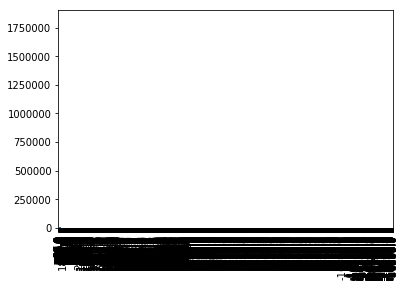

In [26]:
data['membership_length'].value_counts().plot('bar')
plt.show()

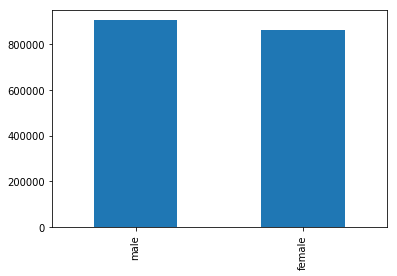

In [32]:
data['gender'].value_counts().plot('bar')
plt.show()

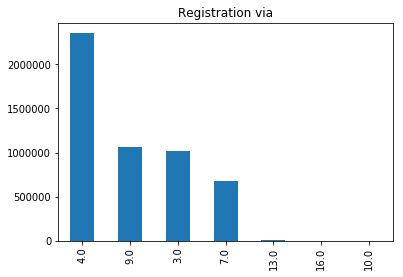

In [35]:
data['registered_via'].value_counts().plot('bar')
plt.title('Registration via')
plt.show()

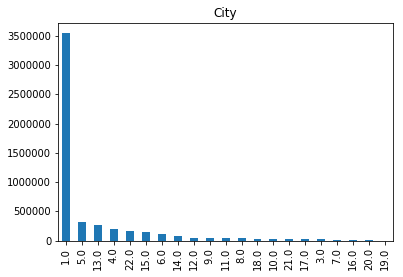

In [36]:
data['city'].value_counts().plot('bar')
plt.title('City')
plt.show()

In [31]:
data.loc['bd'].value_counts()

0    36.0
1    38.0
2    27.0
3    23.0
4    27.0
5    23.0
Name: bd, dtype: float64

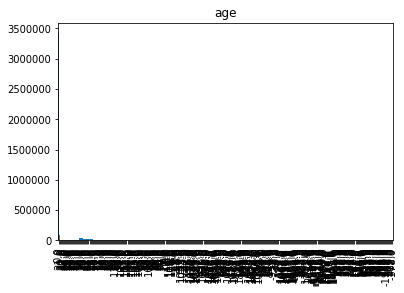

In [27]:
data['bd'].value_counts().plot('bar')
plt.title('age')
plt.show()